<a href="https://colab.research.google.com/github/JarnovdKolk/Test/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"



<ipython-input-4-87fd3e81d2e7>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

Two pre-trained models are downloaded below. Make sure to have adjusted your `CHECKPOINT_PATH` before running this code if not already done.

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define the ReverseDataset class
class ReverseDataset:
    def __init__(self, num_categories, seq_len, size):
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.data = np.random.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)
        return inp_data, labels

# Create dataset and data loaders
def create_data_loaders(num_categories, seq_len, train_size, val_size, test_size, batch_size):
    train_dataset = ReverseDataset(num_categories, seq_len, train_size)
    val_dataset = ReverseDataset(num_categories, seq_len, val_size)
    test_dataset = ReverseDataset(num_categories, seq_len, test_size)

    def generator(dataset):
        for i in range(len(dataset)):
            inp_data, labels = dataset[i]
            yield inp_data, labels

    # Define the output signature for the dataset
    output_signature = (
        tf.TensorSpec(shape=(seq_len,), dtype=tf.int32),  # Input data
        tf.TensorSpec(shape=(seq_len,), dtype=tf.int32)   # Labels
    )

    # Create TensorFlow datasets
    train_loader = tf.data.Dataset.from_generator(
        lambda: generator(train_dataset),
        output_signature=output_signature
    )
    val_loader = tf.data.Dataset.from_generator(
        lambda: generator(val_dataset),
        output_signature=output_signature
    )
    test_loader = tf.data.Dataset.from_generator(
        lambda: generator(test_dataset),
        output_signature=output_signature
    )

    # Batch and prefetch the datasets
    train_loader = train_loader.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_loader = val_loader.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_loader = test_loader.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return train_loader, val_loader, test_loader

# Define the model
class ReversePredictor(models.Model):
    def __init__(self, num_classes, model_dim, num_heads, num_layers, dropout, **kwargs):
        super(ReversePredictor, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = layers.Embedding(num_classes, model_dim)
        self.positional_encoding = self.add_weight(name="positional_encoding",
                                                   shape=(1, 16, model_dim),
                                                   initializer="uniform",
                                                   trainable=True)
        self.transformer_blocks = [layers.MultiHeadAttention(num_heads, model_dim) for _ in range(num_layers)]
        self.dropout_layer = layers.Dropout(dropout)
        self.dense = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x += self.positional_encoding
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, x)
            x = self.dropout_layer(x, training=training)
        x = self.dense(x)
        return x

# Define the training function
def train_reverse(train_loader, val_loader, test_loader, num_classes, model_dim, num_heads, num_layers, dropout, lr, warmup, epochs):
    model = ReversePredictor(num_classes, model_dim, num_heads, num_layers, dropout)
    model.compile(optimizer=Adam(learning_rate=lr), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    checkpoint_callback = ModelCheckpoint(filepath="reverse_task_best_model.h5",
                                          save_best_only=True,
                                          monitor="val_accuracy",
                                          mode="max")

    history = model.fit(train_loader,
                        validation_data=val_loader,
                        epochs=epochs,
                        callbacks=[checkpoint_callback])

    # Load the best model
    model.load_weights("reverse_task_best_model.h5")

    # Evaluate on validation and test sets
    val_result = model.evaluate(val_loader)
    test_result = model.evaluate(test_loader)
    result = {"val_acc": val_result[1], "test_acc": test_result[1]}

    return model, result

# Create data loaders
num_categories = 10
seq_len = 16
train_size = 50000
val_size = 1000
test_size = 10000
batch_size = 128

train_loader, val_loader, test_loader = create_data_loaders(num_categories, seq_len, train_size, val_size, test_size, batch_size)

# Train the model
model, result = train_reverse(train_loader, val_loader, test_loader,
                              num_classes=num_categories,
                              model_dim=32,
                              num_heads=1,
                              num_layers=1,
                              dropout=0.0,
                              lr=5e-4,
                              warmup=50,
                              epochs=10)

print(f"Val accuracy:  {(100.0 * result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * result['test_acc']):4.2f}%")

Epoch 1/10
    391/Unknown 23s 45ms/step - accuracy: 0.1895 - loss: 2.2118

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.1895 - loss: 2.2116 - val_accuracy: 0.2442 - val_loss: 2.0351
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2666 - loss: 1.9693

391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2668 - loss: 1.9688 - val_accuracy: 0.5926 - val_loss: 1.1214
Epoch 3/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7755 - loss: 0.6276

391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.7761 - loss: 0.6261 - val_accuracy: 1.0000 - val_loss: 6.7418e-04
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 1.0000 - loss: 4.6062e-04 - val_accuracy: 1.0000 - val_loss: 1.7019e-04
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 1.0000 - loss: 1.4358e-04 - val_accuracy: 1.0000 - val_loss: 8.3308e-05
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 1.0000 - loss: 7.4217e-05 - val_accuracy: 1.0000 - val_loss: 4.9495e-05
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 1.0000 - loss: 4.5250e-05 - val_accuracy: 1.0000 - val_loss: 3.2349e-05
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 1.0000 - loss: 3.0025e-05 - val_accuracy: 1.0000 - val_loss: 2.2374e-05
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 1.0000 - loss: 2.0975e-05 - val_accuracy: 1.0000 - val_loss: 1.6062e-05
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms

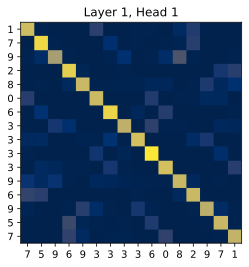

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Extract attention maps from the model
def get_attention_maps(model, input_data):
    attention_maps = []
    x = model.embedding(input_data)
    x += model.positional_encoding
    for transformer_block in model.transformer_blocks:
        attn_output, attn_scores = transformer_block(x, x, return_attention_scores=True)
        attention_maps.append(attn_scores)
        x = attn_output
    return attention_maps

# Function to plot attention maps
def plot_attention_maps(input_data, attn_maps, idx=0):
    input_data = input_data[idx].numpy()
    attn_maps = [m[idx].numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))

    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]

    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")

    fig.subplots_adjust(hspace=0.5)
    plt.show()

# Sample usage
data_input, _ = next(iter(val_loader))
attention_maps = get_attention_maps(model, data_input)
plot_attention_maps(data_input, attention_maps, idx=0)


Epoch 1/10
    391/Unknown 59s 80ms/step - accuracy: 0.1021 - loss: 2.4168

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


391/391 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.1021 - loss: 2.4166 - val_accuracy: 0.1016 - val_loss: 2.3040
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1064 - loss: 2.3044

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1064 - loss: 2.3044 - val_accuracy: 0.1078 - val_loss: 2.3030
Epoch 3/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1107 - loss: 2.3023

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.1107 - loss: 2.3023 - val_accuracy: 0.1113 - val_loss: 2.3022
Epoch 4/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1137 - loss: 2.3010

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1137 - loss: 2.3010 - val_accuracy: 0.1122 - val_loss: 2.3015
Epoch 5/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1151 - loss: 2.3001

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.1151 - loss: 2.3001 - val_accuracy: 0.1126 - val_loss: 2.3012
Epoch 6/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1162 - loss: 2.2995

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1162 - loss: 2.2995 - val_accuracy: 0.1130 - val_loss: 2.3011
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1170 - loss: 2.2989

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.1170 - loss: 2.2989 - val_accuracy: 0.1134 - val_loss: 2.3011
Epoch 8/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1177 - loss: 2.2984

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.1177 - loss: 2.2984 - val_accuracy: 0.1142 - val_loss: 2.3011
Epoch 9/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1183 - loss: 2.2979

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1183 - loss: 2.2979 - val_accuracy: 0.1147 - val_loss: 2.3012
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1190 - loss: 2.2975 - val_accuracy: 0.1138 - val_loss: 2.3014
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1145 - loss: 2.3018
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.1141 - loss: 2.3013
Validation Accuracy: 0.1147, Test Accuracy: 0.1143


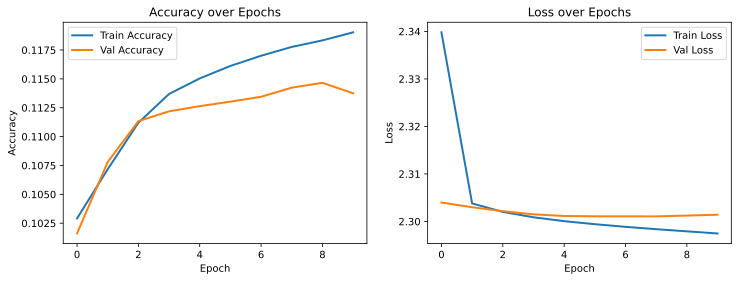

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ==============================
# 1️⃣ Data Preparation
# ==============================
class ReverseDataset:
    def __init__(self, num_categories, seq_len, size):
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.data = np.random.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)  # Reverse sequence as output
        return inp_data, labels

# Create dataset
num_categories = 10
seq_len = 100  # Fixed length input
train_size, val_size, test_size = 50000, 1000, 10000

train_dataset = ReverseDataset(num_categories, seq_len, train_size)
val_dataset = ReverseDataset(num_categories, seq_len, val_size)
test_dataset = ReverseDataset(num_categories, seq_len, test_size)

# Convert dataset into TensorFlow tensors
def create_tf_dataset(dataset, batch_size=128):
    def generator():
        for i in range(len(dataset)):
            inp_data, labels = dataset[i]
            yield inp_data, labels

    output_signature = (
        tf.TensorSpec(shape=(seq_len,), dtype=tf.int32),  # Input data
        tf.TensorSpec(shape=(seq_len,), dtype=tf.int32)   # Output labels
    )

    tf_dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return tf_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_loader = create_tf_dataset(train_dataset)
val_loader = create_tf_dataset(val_dataset)
test_loader = create_tf_dataset(test_dataset)

# ==============================
# 2️⃣ CNN Model Definition (Adjusted for Sequence-to-Sequence)
# ==============================
def build_cnn_model_v2(num_classes, seq_len):
    model = models.Sequential([
        layers.Embedding(input_dim=num_classes, output_dim=32, input_length=seq_len),
        layers.Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv1D(filters=128, kernel_size=7, activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.TimeDistributed(layers.Dense(num_classes, activation="softmax"))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Instantiate the model
model = build_cnn_model_v2(num_classes=num_categories, seq_len=seq_len)

# ==============================
# 3️⃣ Training the Model
# ==============================
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="reverse_cnn_best_model.h5",
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         mode="max")

history = model.fit(train_loader,
                    validation_data=val_loader,
                    epochs=10,
                    callbacks=[checkpoint_callback])

# Load best model
model.load_weights("reverse_cnn_best_model.h5")

# Evaluate the model
val_loss, val_acc = model.evaluate(val_loader)
test_loss, test_acc = model.evaluate(test_loader)
print(f"Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# ==============================
# 4️⃣ Visualizing Results
# ==============================
def plot_results(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

plot_results(history)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ==============================
# 1️⃣ Data Preparation
# ==============================
class ReverseDataset:
    def __init__(self, num_categories, seq_len, size):
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.data = np.random.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.random.randint(self.num_categories, size=(1,))  # Change to single label per sequence
        return inp_data, labels

# Create dataset
num_categories = 10
seq_len = 100  # Fixed length input
train_size, val_size, test_size = 50000, 1000, 10000

train_dataset = ReverseDataset(num_categories, seq_len, train_size)
val_dataset = ReverseDataset(num_categories, seq_len, val_size)
test_dataset = ReverseDataset(num_categories, seq_len, test_size)

# Convert dataset into TensorFlow tensors
def create_tf_dataset(dataset, batch_size=128):
    def generator():
        for i in range(len(dataset)):
            inp_data, labels = dataset[i]
            yield inp_data, labels

    output_signature = (
        tf.TensorSpec(shape=(seq_len,), dtype=tf.int32),  # Input data
        tf.TensorSpec(shape=(seq_len,), dtype=tf.int32)   # Output labels (single class per input)
    )

    tf_dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return tf_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_loader = create_tf_dataset(train_dataset)
val_loader = create_tf_dataset(val_dataset)
test_loader = create_tf_dataset(test_dataset)

# ==============================
# 2️⃣ CNN Model Definition
# ==============================
def build_cnn_model(num_classes, seq_len):
    model = models.Sequential([
        layers.Embedding(input_dim=num_classes, output_dim=32, input_length=seq_len),
        layers.Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
        layers.Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
        layers.Conv1D(filters=64, kernel_size=10, activation="relu", padding="same"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(num_classes, activation="softmax")  # Softmax for classification
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="sparse_categorical_crossentropy",  # Correct loss for class prediction
                  metrics=["accuracy"])
    return model

# Instantiate the model
model = build_cnn_model(num_classes=num_categories, seq_len=seq_len)

# ==============================
# 3️⃣ Training the Model
# ==============================
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="reverse_cnn_best_model.keras",
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         mode="max")

history = model.fit(train_loader,
                    validation_data=val_loader,
                    epochs=10,
                    callbacks=[checkpoint_callback])

# Load best model
model.load_weights("reverse_cnn_best_model.keras")

# Evaluate the model
val_loss, val_acc = model.evaluate(val_loader)
test_loss, test_acc = model.evaluate(test_loader)
print(f"Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# ==============================
# 4️⃣ Visualizing Results
# ==============================
def plot_results(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

plot_results(history)


Epoch 1/10


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 100), output.shape=(None, 10)